# regression-template

Hi 🙂, if you are seeing this notebook, you have succesfully started your first project on FloydHub 🚀, hooray!!
Predicting the price of an object given the historical data is one of the most common task of [ML](https://en.wikipedia.org/wiki/Machine_learning), usually achieved with the [Linear Regression model](https://en.wikipedia.org/wiki/Linear_regression). In this project the Linear Layer will be only the top of the iceberg of a model which combines the wideness of ML model and the deepness of DL model for NLP. The goal is to predict the price of a wine from its description (and variety).

### Predicting price of wine

In this notebook, we will build a classifier to correctly predict the price of a wine from its description. More in detail, we will combine the strength of ML and DL learning using a [Wide & Deep Model](https://medium.com/tensorflow/predicting-the-price-of-wine-with-the-keras-functional-api-and-tensorflow-a95d1c2c1b03), which provides really good performance for Regression and Recommendation tasks.

<img src="https://raw.githubusercontent.com/floydhub/regression-template/master/images/wineprice.png" width="800" height="800" align="center"/>

We will use the [Kaggle's Wine Reviews dataset](https://www.kaggle.com/zynicide/wine-reviews) for training our model. The dataset contains 10 columns and 150k rows of wine reviews.

We will:

- Preprocess text data for NLP
- Build and train a [Wide & Deep model](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on your own movie reviews!


### Instructions
- To execute a code cell, click on the cell and press `Shift + Enter` (shortcut for Run).
- To learn more about Workspaces, check out the [Getting Started Notebook](get_started_workspace.ipynb).
- **Tip**: *Feel free to try this Notebook with your own data and on your own super awesome regression task.*

Now, let's get started! 🚀

## Initial Setup
Let's start by importing the packages, setting the training variables and loading the csv file from which get all the data we need.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
import os
import math
import string
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
layers = keras.layers

## Training Parameters

We'll set the hyperparameters for training our model. If you understand what they mean, feel free to play around - otherwise, we recommend keeping the defaults for your first run 🙂

In [2]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 256  # Number of examples used in each iteration
    EPOCHS = 10  # Number of passes through entire dataset
    MAX_LEN = 170  # Max length of review (in words)
    VOCAB_SIZE = 1000  # Size of vocabulary dictionary
    EMBEDDING = 8  # Dimension of word embedding vector
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 128
    EPOCHS = 10
    MAX_LEN = 170
    VOCAB_SIZE = 1000
    EMBEDDING = 8

## Data

The wine reviews dataset is already attached to your workspace (if you want to attach your own data, [check out our docs](https://docs.floydhub.com/guides/workspace/#attaching-floydhub-datasets)).

Let's take a look at data.

In [3]:
path = '/floyd/data/winereviews/wine_data.csv'  # ADD path/to/dataset

# Convert the data to a Pandas data frame
data = pd.read_csv(path)

# Shuffle the data
data = data.sample(frac=1)

# Print the first 5 rows
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
147097,147098,US,"Aged in American oak, with mostly similar vine...",C'est Beaux,88,35.0,Washington,Columbia Valley (WA),Columbia Valley,Syrah,Walter Dacon
44585,44585,US,"A good, strong, sturdy wine, filled with class...",The Philanthropist Yountville Estate Vineyard,88,52.0,California,Napa Valley,Napa,Cabernet Sauvignon,Markham
38555,38555,France,Dry tannins dominate this wine. Pavie's style ...,NaN,94,NaN,Bordeaux,Saint-Émilion,NaN,Bordeaux-style Red Blend,Château Pavie
57566,57566,US,100% Syrah from the same mix of vineyards as t...,NaN,90,24.0,Washington,Walla Walla Valley (WA),Columbia Valley,Syrah,Watermill
43906,43906,France,The nose displays some funky notes alongside p...,Les Princes Abbés,85,15.0,Alsace,Alsace,NaN,Pinot Blanc,Domaines Schlumberger


## Data Preprocessing

Here are some data cleaning step:

- Remove missing values
- Get only Varieties which appear more frequently (>= 500 times). 

Then split the dataset: 80 (train) - 20 (test).

In [4]:
# Do some preprocessing to limit the # of wine varities in the dataset
# Clean it from null values
data = data[pd.notnull(data['country'])]
data = data[pd.notnull(data['price'])]
data = data.drop(data.columns[0], axis=1) 

variety_threshold = 500 # Anything that occurs less than this will be removed.
value_counts = data['variety'].value_counts()
to_remove = value_counts[value_counts <= variety_threshold].index
data.replace(to_remove, np.nan, inplace=True)
data = data[pd.notnull(data['variety'])]

# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 95646
Test size: 23912


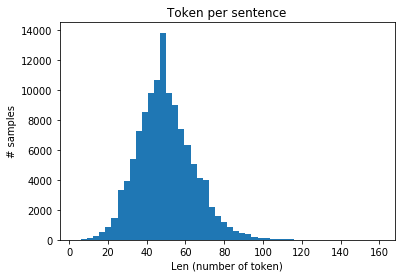

In [5]:
# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in data['description'].values], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

The *Tokens per sentence* plot (see above) is useful for setting the `MAX_LEN` training hyperparameter.

In [6]:
# Train features
description_train = data['description'][:train_size]
variety_train = data['variety'][:train_size]

# Train labels
labels_train = data['price'][:train_size]

# Test features
description_test = data['description'][train_size:]
variety_test = data['variety'][train_size:]

# Test labels
labels_test = data['price'][train_size:]

## Wide Representation: BoW

The Code below will encode the description of each sentence using the  [BoW model](https://en.wikipedia.org/wiki/Bag-of-words_model). This representation will encode each sentence to a vector that keeps track of the entries in the vocabulary which are used in the current sentences. This step will build a sparse vector(a vector with mostly zero values) for each description. The Code provides an example to help you get the intuition behind it.

The **wide**  term used for defining this model is due to the sparse representation that this type of encoding carried out.

In [7]:
print("First Original Sample:", data['description'].values[0])
# Create a tokenizer to preprocess our text descriptions
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, char_level=False)
tokenizer.fit_on_texts(description_train) # only fit on train

# Wide feature 1: sparse bag of words (bow) vocab_size vector 
description_bow_train = tokenizer.texts_to_matrix(description_train)
description_bow_test = tokenizer.texts_to_matrix(description_test)
print("\nFirst Sample after BoW (sparse representation truncated at the first 100 vocabulary terms):", description_bow_train[0][:100])

# Wide feature 2: one-hot vector of variety categories
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(variety_train)
variety_train = encoder.transform(variety_train)
variety_test = encoder.transform(variety_test)
num_classes = np.max(variety_train) + 1

# Convert labels to one hot
variety_train = keras.utils.to_categorical(variety_train, num_classes)
variety_test = keras.utils.to_categorical(variety_test, num_classes)

First Original Sample: Aged in American oak, with mostly similar vineyard sources. The American oak, with more spice to the fruit, and less smoothness overall than the C'est Belle Bottling. Cherry and berry flavors abound; it's sturdy, solid and well-made. Just 170 cases produced.

First Sample after BoW (sparse representation truncated at the first 100 vocabulary terms): [0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


## Wide Model

The model will use the BoW representation for the *wine description* and One-Hot encoding representation for the *wine variety* as Features for the Wide Model (a 2 layers NN).

<img src="https://raw.githubusercontent.com/floydhub/regression-template/master/images/wide.png" width="350" height="350" align="center"/>


*Image from the [paper](https://arxiv.org/pdf/1606.07792.pdf)*

In [8]:
# Define our wide model with the functional API
bow_inputs = layers.Input(shape=(VOCAB_SIZE,))
variety_inputs = layers.Input(shape=(num_classes,))
merged_layer = layers.concatenate([bow_inputs, variety_inputs])
merged_layer = layers.Dense(256, activation='relu')(merged_layer)
predictions = layers.Dense(1)(merged_layer)
wide_model = keras.Model(inputs=[bow_inputs, variety_inputs], outputs=predictions)

wide_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
print(wide_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1040)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          266496      concatenate_1[0][0]              
__________

## Deep Representation: Embedding

The Code below will encode the description of each sentence using [Word Embedding](https://en.wikipedia.org/wiki/Word_embedding). This representation will encode each word of the sentence into a vector. Before applying this encoding we need to preprocess the wine description by converting each token to an index and pad the sentence to the same length.

In [9]:
print("First Original Sample:", data['description'].values[0])

# Deep model feature: word embeddings of wine descriptions
train_embed = tokenizer.texts_to_sequences(description_train)
test_embed = tokenizer.texts_to_sequences(description_test)

train_embed = keras.preprocessing.sequence.pad_sequences(
    train_embed, maxlen=MAX_LEN, padding="post")
test_embed = keras.preprocessing.sequence.pad_sequences(
    test_embed, maxlen=MAX_LEN, padding="post")

print("\nFirst Sample after Preprocessing for Embedding:", train_embed[0])

First Original Sample: Aged in American oak, with mostly similar vineyard sources. The American oak, with more spice to the fruit, and less smoothness overall than the C'est Belle Bottling. Cherry and berry flavors abound; it's sturdy, solid and well-made. Just 170 cases produced.

First Sample after Preprocessing for Embedding: [362  10  33   5 789 135   2  33   5  59  35  11   2  13   1 509 312 122
   2 349  19   1  44   8  17 911 183   1  55 124  89 495 523   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0

## Deep Model

This model build a liner layer at the top of the word embedding representaion of the wine description. 

<img src="https://raw.githubusercontent.com/floydhub/regression-template/master/images/deep.png" width="450" height="450" align="center"/>

*Image from the [paper](https://arxiv.org/pdf/1606.07792.pdf)*

In [10]:
# Define our deep model with the Functional API
deep_inputs = layers.Input(shape=(MAX_LEN,))
embedding = layers.Embedding(VOCAB_SIZE, EMBEDDING, input_length=MAX_LEN)(deep_inputs)
embedding = layers.Flatten()(embedding)
embed_out = layers.Dense(1)(embedding)
deep_model = keras.Model(inputs=deep_inputs, outputs=embed_out)
print(deep_model.summary())

deep_model.compile(loss='mse',
                       optimizer='adam',
                       metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 170, 8)            8000      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1360)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1361      
Total params: 9,361
Trainable params: 9,361
Non-trainable params: 0
_________________________________________________________________
None


## Wide & Deep Model

We will implement a model similar to Heng-Tze Cheng’s [Wide & Deep Learning for Recommender Systems](https://arxiv.org/pdf/1606.07792.pdf). 

This model catenate the output of the previous models and build an additional linear layer at the top.

<img src="https://raw.githubusercontent.com/floydhub/regression-template/master/images/wide&deep.png" width="500" height="500" align="center"/>

*Image from the [paper](https://arxiv.org/pdf/1606.07792.pdf)*

In [11]:
# Combine wide and deep into one model
merged_out = layers.concatenate([wide_model.output, deep_model.output])
merged_out = layers.Dense(1)(merged_out)
combined_model = keras.Model(wide_model.input + [deep_model.input], merged_out)
print(combined_model.summary())

combined_model.compile(loss='mse',
                       optimizer='adam',
                       metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 170)          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1040)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________

## Train& Eval

If you left the default hyperpameters in the Notebook untouched, your training should take approximately:

- On CPU machine: 1 minutes for 10 epochs.
- On GPU machine: 30 seconds for 10 epochs.

In [12]:
# Run training
combined_model.fit([description_bow_train, variety_train] + [train_embed], labels_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
95646/95646 [==============================] - 6s 66us/step - loss: 1135.1612 - acc: 0.0261
Epoch 2/10
95646/95646 [==============================] - 6s 61us/step - loss: 941.6884 - acc: 0.0326
Epoch 3/10
95646/95646 [==============================] - 6s 62us/step - loss: 880.5090 - acc: 0.0344
Epoch 4/10
95646/95646 [==============================] - 6s 61us/step - loss: 815.9317 - acc: 0.0345
Epoch 5/10
95646/95646 [==============================] - 6s 63us/step - loss: 742.0993 - acc: 0.0358
Epoch 6/10
95646/95646 [==============================] - 6s 64us/step - loss: 665.1590 - acc: 0.0362
Epoch 7/10
95646/95646 [==============================] - 6s 64us/step - loss: 588.6375 - acc: 0.0372
Epoch 8/10
95646/95646 [==============================] - 6s 64us/step - loss: 518.4199 - acc: 0.0388
Epoch 9/10
95646/95646 [==============================] - 6s 63us/step - loss: 448.8580 - acc: 0.0386
Epoch 10/10
95646/95646 [==============================] - 6s 63us/step - loss: 3

In [13]:
combined_model.evaluate([description_bow_test, variety_test] + [test_embed], labels_test, batch_size=BATCH_SIZE)

23912/23912 [==============================] - 1s 21us/step


[1050.6474193012727, 0.03379056540711363]

In [14]:
from ipywidgets import interact
from ipywidgets import widgets

def evaluate(num_predictions):
    # Generate predictions
    predictions = combined_model.predict([description_bow_test, variety_test] + [test_embed])

    # Compare predictions with actual values for the first few items in our test dataset
    diff = 0
    for i in range(num_predictions):
        val = predictions[i]
        print('[{}] - {}'.format(i+1, description_test.iloc[i]))
        print('Predicted: ', val[0], 'Actual: ', labels_test.iloc[i], '\n')
        diff += abs(val[0] - labels_test.iloc[i])

    # Compare the average difference between actual price and the model's predicted price
    print('Average prediction difference: ', diff / num_predictions)

interact(evaluate, num_predictions=widgets.IntSlider(value=1, min=1, max=20, description='# of test to evaluate/show'));

interactive(children=(IntSlider(value=1, description='# of test to evaluate/show', max=20, min=1), Output()), …

## It's your turn

Test out the model you just trained. Run the code Cell below and type your reviews in the widget, Have fun!🎉

Here are some inspirations:

- **Description**: 'From 18-year-old vines, this supple well-balanced effort blends flavors of mocha, cherry, vanilla and breakfast tea. Superbly integrated and delicious even at this early stage, this wine seems destined for a long and savory cellar life. Drink now through 2028.', **Variety**: 'Pinot Noir'.
- **Description**: 'The Quarts de Chaume, the four fingers of land that rise above the Layon Valley, are one of the pinnacles of sweet wines in the Loire. Showing botrytis and layers of dryness over the honey and peach jelly flavors, but also has great freshness. The aftertaste just lasts.', **Variety**: 'Chenin Blanc'.
- **Description**: 'Nicely oaked blackberry, licorice, vanilla and charred aromas are smooth and sultry. This is an outstanding wine from an excellent year. Forward barrel-spice and mocha flavors adorn core blackberry and raspberry fruit, while this runs long and tastes vaguely chocolaty on the velvety finish. Enjoy this top-notch Tempranillo through 2030.', **Variety**: 'Tempranillo'.
- **Description**: 'Bright, light oak shadings dress up this medium-bodied wine, complementing the red cherry and strawberry flavors. Its fresh, fruity and not very tannic—easy to drink and enjoy.', **Variety**: 'Sauvignon Blanc'.
- **Description**: 'This wine features black cherry, blackberry, blueberry with aromas of black licorice and earth. Ending with a creamy vanilla finish.', **Variety**: 'Syrah'.

Can you do better? Play around with the model hyperparameters!

In [15]:
from ipywidgets import interact_manual
from ipywidgets import widgets


def get_prediction(test_description, test_variety):
    # Wide model features
    bow_description = tokenizer.texts_to_matrix([test_description])
    variety = encoder.transform([test_variety])
    variety = keras.utils.to_categorical(variety, len(encoder.classes_))
    
    # Deep model feature: word embeddings of wine descriptions
    embed_description = tokenizer.texts_to_sequences([test_description])
    embed_description = keras.preprocessing.sequence.pad_sequences(
        embed_description, maxlen=MAX_LEN, padding="post")
    

    # Evaluate
    predictions = combined_model.predict([bow_description, variety] + [embed_description])
    print('DESCRIPTION:', test_description)
    print('VARIETY:', test_variety)
    print('PREDICTED:', predictions[0][0])
    
interact_manual(get_prediction, 
                test_description=widgets.Textarea(placeholder='Type a wine Description here'),
                test_variety=widgets.Text(placeholder='Type a wine Variety here'));

interactive(children=(Textarea(value='', description='test_description', placeholder='Type a wine Description …

## Save your model

In [16]:
import pickle

# Saving Tokenizer
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Variety Encode
with open('models/encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Saving Model Weight
combined_model.save_weights('models/wide_and_deep_weights.h5')

##### That's all folks - don't forget to shutdown your workspace once you're done 🙂